# 07. AdaBoostによる教師あり学習


---
## 目的
AdaBoostを用いて2つのサンプルの識別を行う．その後，交差検定法を用いて識別テストを行う．


## プログラムの動作

`07_AdaBoost.py`を実行すると，`data/car.txt`と`data/human.txt`の2つ読み込む．次に，AdaBoostによる学習およびテストを交差検定法を用いて行う．最後に，識別率と識別されたグラフを表示する．


## 準備
プログラムの動作に必要なデータをダウンロードし，zipファイルを解凍する．

In [0]:
!wget -q http://www.mprg.cs.chubu.ac.jp/tutorial/ML_Lecture/sklearn/data.zip
!unzip -q data.zip
!ls
!ls ./data

data  data.zip	__MACOSX  sample_data
car.txt  human.txt


##モジュールのインポート
初めに，必要なモジュールをインポートする．

今回は新たに`AdaBoostClassifier`と`DecisionTreeClassifier`をインポートし，2つを組み合わせて用いる．このように，AdaBoostは他の学習方法と組み合わせてパフォーマンスを上げることができる．

In [0]:
from os import path
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import model_selection

##データの読み込み
次に，テキストファイルを読み込む．
これまでと同じであるため，説明は割愛する．

In [0]:
in_txt1 = open(path.join('data', 'car.txt'))
in_txt2 = open(path.join('data', 'human.txt'))

car = np.asarray([(line.strip()).split('\t') for line in in_txt1], dtype=float)
print(car.shape)
human = np.asarray([(line.strip()).split('\t') for line in in_txt2], dtype=float)
print(human.shape)

(110, 2)
(382, 2)


## データのラベル付けと結合，交差検定法の準備
学習を行う前に，データがcarまたはhumanどちらのクラスに属するかラベル付けをする．

In [0]:
car_y =  np.zeros(car.shape[0])
human_y = np.ones(human.shape[0])
X= np.r_[car, human]
y= np.r_[car_y, human_y]

kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
print(X.shape, y.shape)

(492, 2) (492,)


## 学習と評価
for文で学習と評価をk回繰り返す．


In [0]:
scores = []
best_score = 0.0

for train, test in kfold.split(X):
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200)
    classifier.fit(X[train], y[train])
    preds = classifier.predict(X[test])
    score = metrics.accuracy_score(preds, y[test])
    scores.append(score)

    if score > best_score:
        best_classifier = classifier
        best_score = score

`classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200)`が識別器の定義となる．今回はAdaBoostとDecisionTree（決定木）を用いる．主なパラメータとして`max_depth`と`algorithm`と`n_estimators`がある．

- `max_depth`: 決定木の最大の深さ **1のまま変更しないこと**
- `algorithm`: 利用するアルゴリズム．`SAMME`と`SAMME.R`がある．
- `n_estimators`: 弱識別器の数．


## 識別率の計算
得られたk個の結果を平均して，識別率を求める．

In [0]:
accuracy = (sum(scores) / len(scores)) * 100
msg = 'recognition rate: {accuracy:.2f}%'.format(accuracy=accuracy)
print(msg)

recognition rate: 96.34%


## グラフの描画
識別結果を可視化するためにグラフを作成する．どちらのクラスがどの領域かわかりやすく表示することができる．

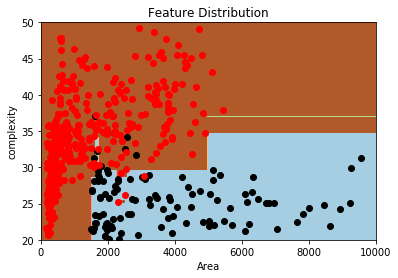

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure()
subfig = fig.add_subplot(1,1,1)
plt.xlim(0, 10000)
plt.ylim(20, 50)

xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 500),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 500))

Z = best_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

subfig.scatter(car[:,0], car[:,1],color='black')
subfig.scatter(human[:,0], human[:,1],color='red')

subfig.set_title('Feature Distribution')
subfig.set_xlabel('Area')
subfig.set_ylabel('complexity')

plt.savefig("07_graph.png")
plt.show()

## 課題
1. 弱識別器の数（`n_estimators`）を変化させると識別境界はどう変化するか．グラフで確認せよ．
2. 識別率の最も高くなる弱識別器の数（`n_estimators`）を求めよ．


## ヒント
1. 学習を行いすぎるとどうなるか．
2. 200だと若干過学習気味である．もう少し減らしてみると良い．